In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pickle

In [3]:
proj_name = "HypoMap_Steuernagel"
file_name = "HypoMap_Steuernagel"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

ccd.ul.set_seed(seed)

In [4]:
adata =  sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 384925 × 51676
    obs: 'SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named', 'C66_named', 'C185_named', 'C286_named', 'C465_named', 'Author_Class_Curated', 'Author_CellType', 'Region_summarized', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'feature_name', 'feature_reference', 'feature

# upload obsm from h5 file

In [5]:
import h5py

h5_path = "../save/obsm_concord-1.0.3_Jul03/obsm_HypoMap_Steuernagel_Jul07-1023.h5"

def print_h5_structure(g, prefix=""):
    for key in g.keys():
        item = g[key]
        if isinstance(item, h5py.Group):
            print(f"{prefix}{key}/ (Group)")
            print_h5_structure(item, prefix=prefix + key + "/")
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}{key:50s} shape: {item.shape}")

with h5py.File(h5_path, 'r') as f:
    print_h5_structure(f)

obsm/ (Group)
obsm/X_umap                                             shape: (384925, 2)
obsm/concord_hcl                                        shape: (384925, 50)
obsm/concord_hcl_UMAP                                   shape: (384925, 2)
obsm/concord_hcl_UMAP_3D                                shape: (384925, 3)
obsm/concord_knn                                        shape: (384925, 50)
obsm/concord_knn_UMAP                                   shape: (384925, 2)
obsm/concord_knn_UMAP_3D                                shape: (384925, 3)
obsm/contrastive                                        shape: (384925, 50)
obsm/contrastive_UMAP                                   shape: (384925, 2)
obsm/contrastive_UMAP_3D                                shape: (384925, 3)
obsm/harmony                                            shape: (384925, 50)
obsm/harmony_UMAP                                       shape: (384925, 2)
obsm/harmony_UMAP_3D                                    shape: (384925, 3)
obsm/li

In [7]:
obsm_keys_to_copy = [
    "contrastive_UMAP", "contrastive_UMAP_3D",
    "harmony_UMAP", "harmony_UMAP_3D",
    "scanorama_UMAP", "scanorama_UMAP_3D",
    "scvi_UMAP", "scvi_UMAP_3D",
    "unintegrated_UMAP", "unintegrated_UMAP_3D",
    "liger_UMAP", "liger_UMAP_3D",
]

In [8]:
with h5py.File(h5_path, 'r') as f:
    obsm_group = f['obsm']
    for key in obsm_keys_to_copy:
        if key in obsm_group:
            data = obsm_group[key][:]
            assert data.shape[0] == adata.n_obs, f"Shape mismatch for {key}"
            print(f"✅ Appending: {key}")
            adata.obsm[key] = data
        else:
            print(f"⚠️  Skipped (not found): {key}")

✅ Appending: contrastive_UMAP
✅ Appending: contrastive_UMAP_3D
✅ Appending: harmony_UMAP
✅ Appending: harmony_UMAP_3D
✅ Appending: scanorama_UMAP
✅ Appending: scanorama_UMAP_3D
✅ Appending: scvi_UMAP
✅ Appending: scvi_UMAP_3D
✅ Appending: unintegrated_UMAP
✅ Appending: unintegrated_UMAP_3D
✅ Appending: liger_UMAP
✅ Appending: liger_UMAP_3D


In [9]:
adata.write(data_dir / f"{file_name}_final.h5ad")

In [10]:
adata

AnnData object with n_obs × n_vars = 384925 × 51676
    obs: 'SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named', 'C66_named', 'C185_named', 'C286_named', 'C465_named', 'Author_Class_Curated', 'Author_CellType', 'Region_summarized', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'feature_name', 'feature_reference', 'feature

----

# time and memory profiling

In [4]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

✅ Benchmark summary saved to: ../save/HypoMap_Steuernagel-Jul28-1550/benchmark_summary_Jul28-1550.tsv


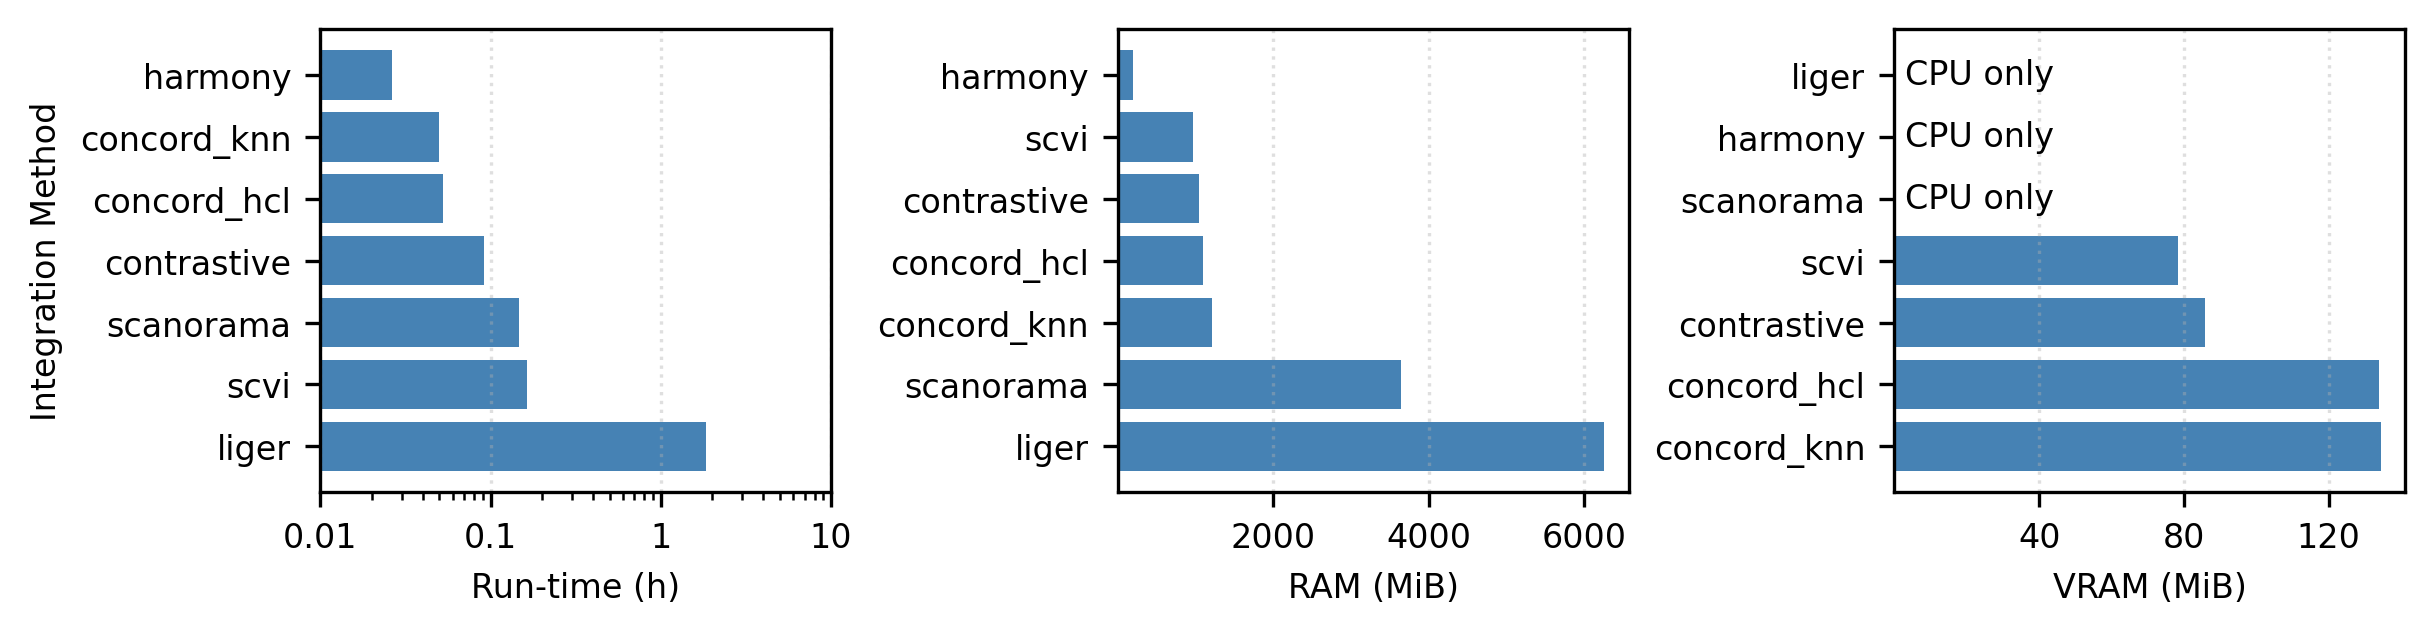

In [5]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               save_path = save_dir / f"benchmark_plot_{file_suffix}.svg",
                               label_fontsize=8)


----

# UMAP

In [6]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

batch_key = 'Batch_ID'
state_key = 'cell_type'

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


# refine state_key (cell_type_refined) for benchmarking

In [6]:
def refine_cell_type(row):
    if row["cell_type"] == "neuron":
        if "GLU" in row["C25_named"]:
            return f"neuron: {row['C25_named'].split(': ')[1]}"
        elif "GABA" in row["C25_named"]:
            return f"neuron: {row['C25_named'].split(': ')[1]}"
        else:
            return "neuron: others"
    else:
        return row["cell_type"]

# Apply to create new column
adata.obs["cell_type_refined"] = adata.obs.apply(refine_cell_type, axis=1)


In [7]:
adata.obs['cell_type'].value_counts()

cell_type
neuron                            219360
astrocyte                          52186
oligodendrocyte                    48817
oligodendrocyte precursor cell     19865
microglial cell                    14304
endothelial cell                   10261
tanycyte                            9737
ependymal cell                      4425
mural cell                          3776
fibroblast                          1372
pituitary gland cell                 729
hypendymal cell                       52
erythrocyte                           41
Name: count, dtype: int64

In [8]:
adata.obs['cell_type_refined'].value_counts()

cell_type_refined
neuron: GABA-2                    54347
astrocyte                         52186
oligodendrocyte                   48817
neuron: GABA-1                    43532
neuron: GLU-3                     41728
neuron: GLU-2                     23150
oligodendrocyte precursor cell    19865
microglial cell                   14304
neuron: GABA-4                    10639
endothelial cell                  10261
tanycyte                           9737
neuron: GABA-5                     8770
neuron: GLU-5                      8592
neuron: GLU-4                      7531
neuron: GLU-8                      6812
neuron: GABA-3                     4930
ependymal cell                     4425
neuron: GABA-6                     4103
mural cell                         3776
neuron: GLU-6                      2408
neuron: GLU-1                      1396
fibroblast                         1372
pituitary gland cell                729
neuron: GLU-7                       675
neuron: others        

In [9]:
# save adata
adata.write(data_dir / f"{file_name}_final.h5ad")

# UMAP (new state key)

In [7]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

batch_key = 'Batch_ID'
state_key = 'cell_type_refined'

concord.plotting.pl_embedding - INFO - Plotting unintegrated with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with Batch_ID in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with Batch_ID in UMAP


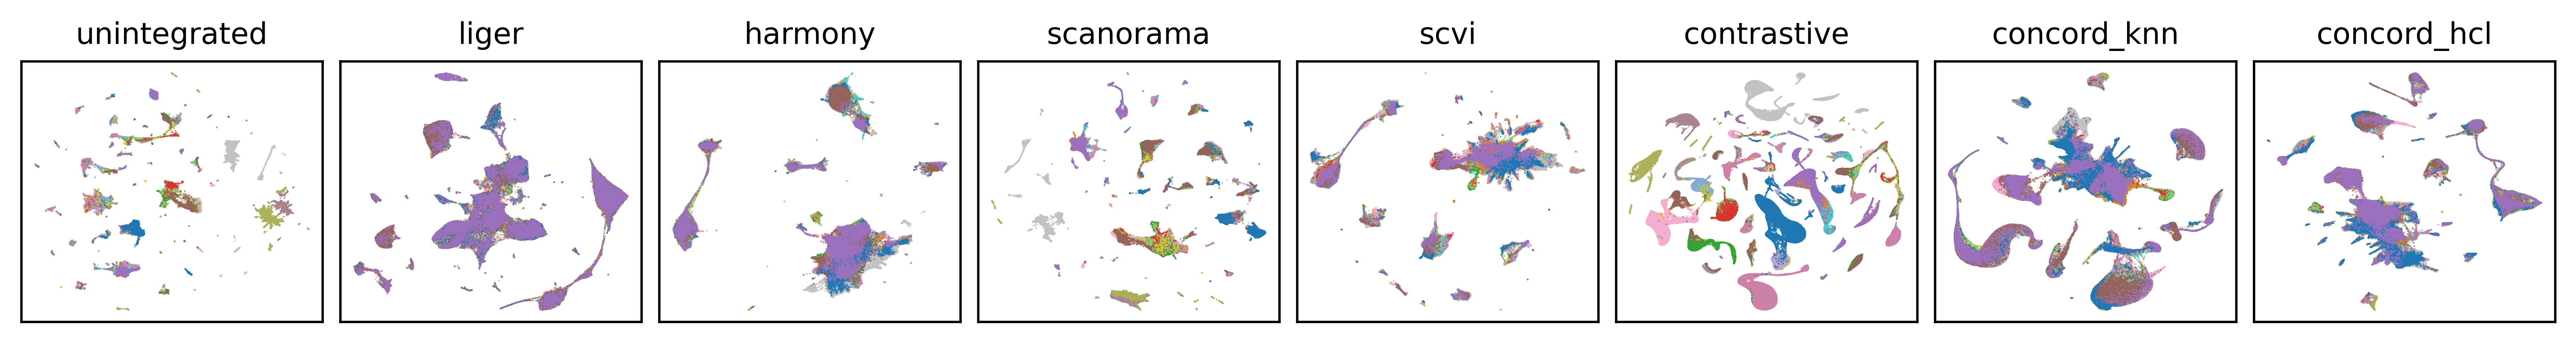

concord.plotting.pl_embedding - INFO - Plotting unintegrated with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with cell_type_refined in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with cell_type_refined in UMAP


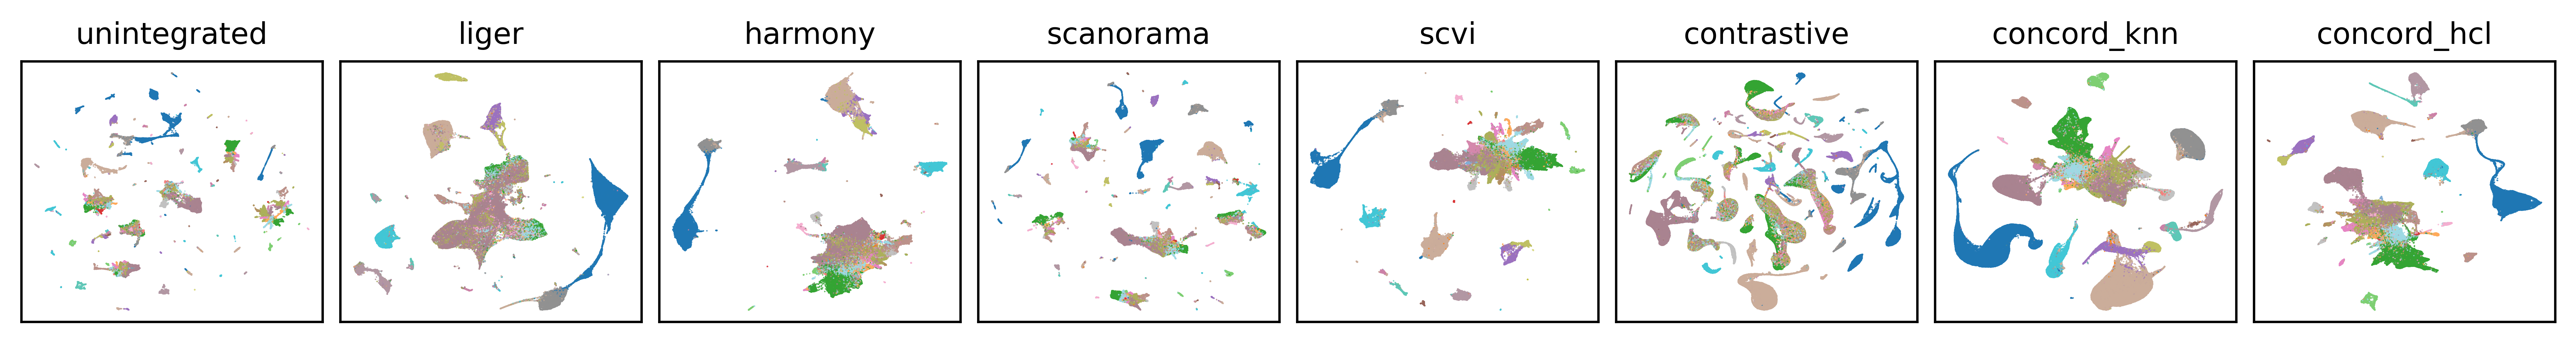

In [8]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )
